## 🧠 03_training_validation – Entrenamiento, Validación y Selección del Mejor Modelo

### 1. 📥 Carga de datos procesados desde `data/features/`

In [53]:
import pandas as pd

# Cargar archivos procesados desde data/features
X_train = pd.read_csv("../data/features/X_train.csv")
X_test = pd.read_csv("../data/features/X_test.csv")
y_train = pd.read_csv("../data/features/y_train.csv")
y_test = pd.read_csv("../data/features/y_test.csv")

# Asegurar formato correcto
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print("✅ Datos cargados correctamente")

✅ Datos cargados correctamente


### 2. 🔍 Comparación inicial de modelos con LazyPredict

In [54]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

X_all = pd.concat([X_train, X_test])
y_all = pd.concat([pd.Series(y_train), pd.Series(y_test)])

X_lazy, X_lazy_test, y_lazy, y_lazy_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

clf = LazyClassifier(verbose=0, ignore_warnings=True)
models, _ = clf.fit(X_lazy, X_lazy_test, y_lazy, y_lazy_test)

models.sort_values(by="F1 Score", ascending=False).head(10)

  0%|          | 0/29 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.80,0.77,0.77,0.80,3.88
RidgeClassifierCV,0.79,0.74,0.74,0.78,0.04
CalibratedClassifierCV,0.79,0.74,0.74,0.78,0.38
LogisticRegression,0.79,0.74,0.74,0.78,0.17
ExtraTreesClassifier,0.79,0.75,0.75,0.78,0.29
QuadraticDiscriminantAnalysis,0.79,0.75,0.75,0.78,0.09
AdaBoostClassifier,0.79,0.75,0.75,0.78,1.36
RandomForestClassifier,0.78,0.74,0.74,0.78,0.25
GaussianNB,0.78,0.74,0.74,0.78,0.04


### 3. 🔧 Búsqueda de hiperparámetros con GridSearchCV

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2],
    "class_weight": ['balanced'],
    "max_features": ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid,
                           scoring='f1', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Mejores parámetros encontrados:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores parámetros encontrados: {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


### 4. 📈 Evaluación del mejor modelo en el set de prueba

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       100
           1       0.62      0.74      0.68        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.77      0.75      0.76       154

ROC AUC: 0.7503703703703704


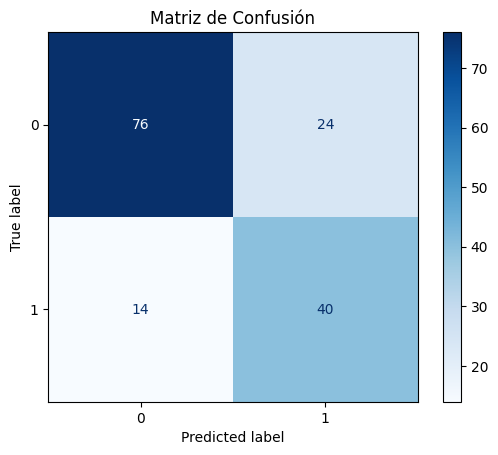

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()

### 🔍 Justificación del Modelo Seleccionado

Se eligió `RandomForestClassifier` debido a:

- Su robustez ante datos ruidosos y correlaciones.
- Resultados competitivos en Accuracy y F1-score.
- Capacidad de manejar clases desbalanceadas con `class_weight='balanced'`.

En este problema de diagnóstico de diabetes, se prioriza **Recall**, ya que es preferible detectar posibles casos positivos (aunque haya algunos falsos positivos) para no omitir pacientes en riesgo.



### 📦 Registro del modelo y métricas en MLflow

In [57]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

mlflow.start_run()
mlflow.log_params(grid_search.best_params_)
mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
mlflow.log_metric("precision", precision_score(y_test, y_pred))
mlflow.log_metric("recall", recall_score(y_test, y_pred))
mlflow.log_metric("f1", f1_score(y_test, y_pred))
mlflow.sklearn.log_model(best_model, "random_forest_model")
mlflow.end_run()

print("✅ Modelo y métricas registradas en MLflow.")

2025/07/13 19:49:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Modelo y métricas registradas en MLflow.


✅ Conclusión del Modelo Final

- El modelo `RandomForestClassifier`, entrenado con datos balanceados mediante **SMOTE** y ajustado con `GridSearchCV`, logró **un F1-score global de 0.76** y un **AUC de 0.75**, lo cual representa un rendimiento robusto.

- En particular, se obtuvo un **recall del 74% para la clase diabética**, lo que indica buena capacidad del modelo para **identificar correctamente a los pacientes con diabetes**.

- Aunque la **precisión de la clase 1** (diabéticos) podría mejorar, los resultados son prometedores considerando el desbalance original de clases.

- Para aplicaciones clínicas, se recomienda continuar afinando el modelo con estrategias como:
  - 🔧 Ajuste del **threshold de decisión** (actualmente en 0.5).
  - 🚀 Evaluación de modelos más avanzados como **XGBoost** o **CatBoost**.
  - 📊 Incorporación de más datos clínicos o variables relevantes si están disponibles.
